<a href="https://colab.research.google.com/drive/1FGUBVt7rQHeBfsVeBr60wO5YIFmcZ2LT?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-18 15:25:47--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-18 15:25:47 (39.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

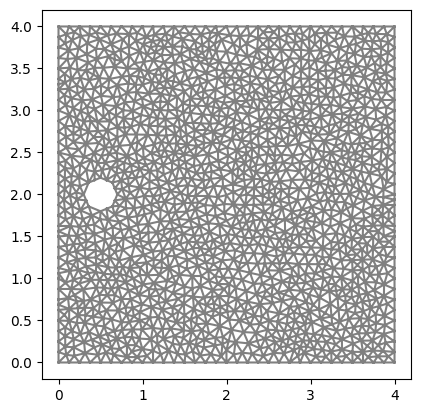

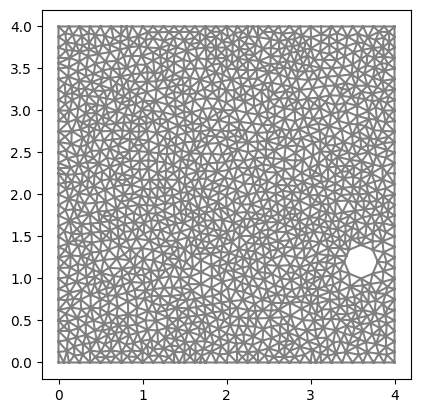

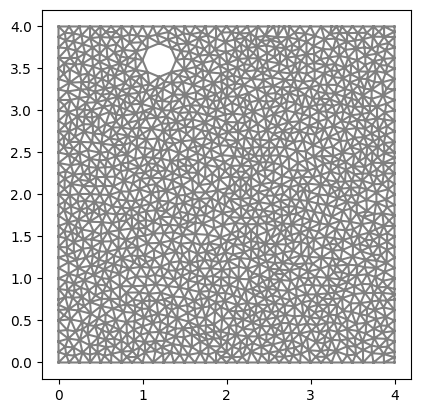

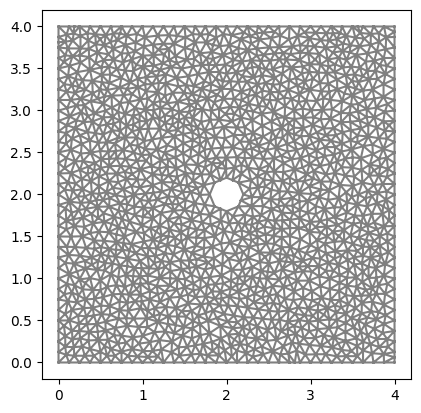

In [ ]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
circles = [(0.5,0.5*H), (0.9*L, 0.3*H), (0.3*L, 0.9*H), (0.5*L, 0.5*H)]
rc = 0.2
# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
meshs = [generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution) for (xc, yc) in circles]

for mesh in meshs:
  plt.figure()
  plot(mesh)
  plt.show()

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8dcc7ff1a2a5155b4ca8e0d58559cea9e604269b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00451016 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.427403 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00518394 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0268536 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00509715 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0187173 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00743985 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0231905 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_427354de98fd75991c5da722635e573416848414

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00870228 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.857324 seconds.

INFO:FFC:Compiler stage 3

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_780eb9ddb42feb9c6996c1225460f0d8c3f18bb9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00313497 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0299373 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_41fc19b0227ffaf8fed5947dd0f32b7293c796d5

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00498486 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0228167 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_29f63fc2f6192c2ea8456e7c194a27721568f319

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              6
  Coefficients:                        '[f_70, f_82, f_83, f_85, f_86, f_87]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                      

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00371122 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.018075 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00440073 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0119057 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_55a2fc928615c00de576df7fa40f1343537f726c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              3
  Coefficients:                        '[f_83, f_85, f_86]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?
                            

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bb1be0e4f3c0e3b86fae8f14d5132771fc0e3c1e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              7
  Coefficients:                        '[f_79, f_83, f_85, f_86, f_88, f_89, f_90]'
  Unique elements:                     'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d67966e0b4802e12b02f9a3e21738e9fb35809b6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              3
  Coefficients:                        '[f_83, f_85, f_86]'
  Unique elements:                     'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG3(?,?
                            

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c6b4a02fee68f7686f0465e333e494b06b61787f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0478549 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3d05bc04ea75b80e5d525a8396e89d2f4a6304b6

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00593066 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0182426 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_a712bb565d87c5e1d5625ade0197191374301487

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00927019 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0189695 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d123cefaaa5b67d0e0b75375e2b0e3f4ea1f443f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00466847 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0171771 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_949fd8d0ce307bb0cc6395b639b6fb3c4f39bfdb

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00430489 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0161502 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_57e62bc067fd4e90a89fa19b659b6c786f0f36f6

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00466561 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0121169 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c9dbef7cf00a55c7da61d3f11cce356cbed02771

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_70]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c9a169dd48fec4c87377f4d20ffcd2cd87f501ec

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00295615 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0157146 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4c58925ba7416ca95a1ece370e5d12c1ae3d39d2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.038017 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a97d4b782d2133a79f90f27b1406c8d68e32bdcd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_70]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2a5d85190d54ec0bc620cfbe9bdd18861049e7e1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_79]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG3(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG3(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), Vector<2 x CG3(?
                             ,?)>, CG1(?,?), CG3(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7a593078c8b133b1d9d9352910516b7ae21a507b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00284481 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0217559 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_fa80da179f648b9c6390895a826dad3876fe358d

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0138586 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0336823 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f8506709943c226fd9c6530a878c70f987370e63

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00757551 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0243258 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0c97cb55a905b3f54a79504b3bcbf1760ce26361

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_79]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG3(?,?)>, CG2(?,?), CG3(?,
                             ?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --

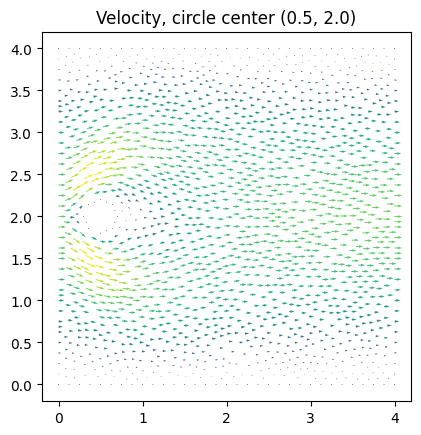

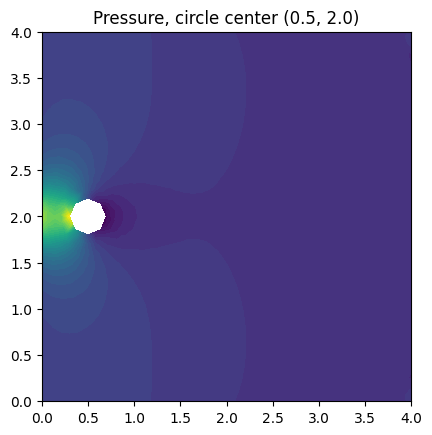

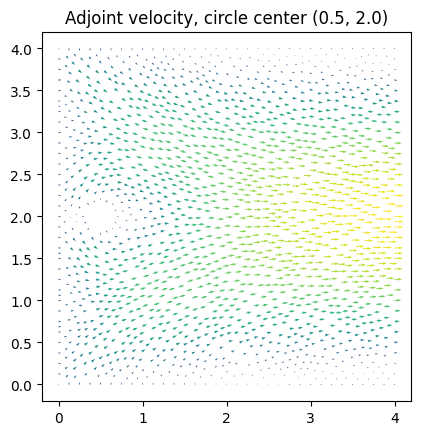

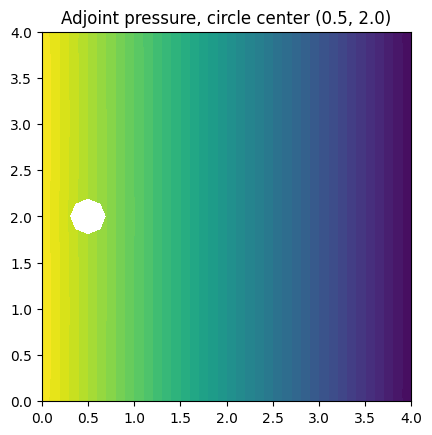

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cd40aaaf5bc0b68be1a587d7bb9a08da6d0820e7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00485015 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0220282 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_df748620648d7f4759057d0d9925bce7e8de913a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_70, f_79, f_87]'
  Unique elements:           'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                             <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x CG2(?,?)>,
                              Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                             <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x CG2(?,?)>,
                              Vector<2 x CG1(?,?)>, CG1(?,?), V

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_5dc1e52a604d6ddbecca2ca8e6f4a8a55fc4ee06

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00279403 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.025939 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

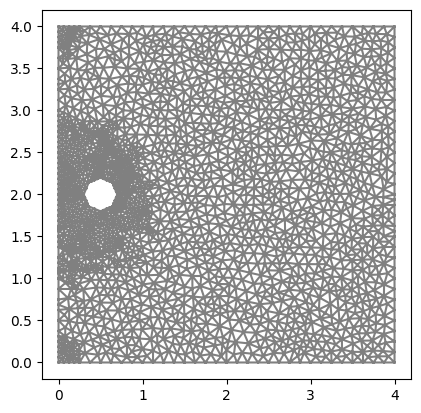

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f20350d4acd48e105a0abdfdc5669dc116b6e295

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              7
  Coefficients:                        '[f_70, f_79, f_82, f_83, f_85, f_86, f_87]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                                       <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x 
                                       CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mi

Total error = 3.974688094121942e-05


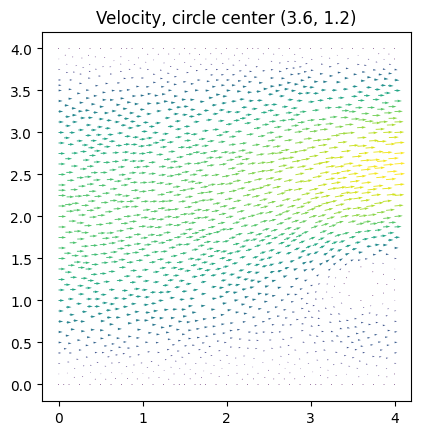

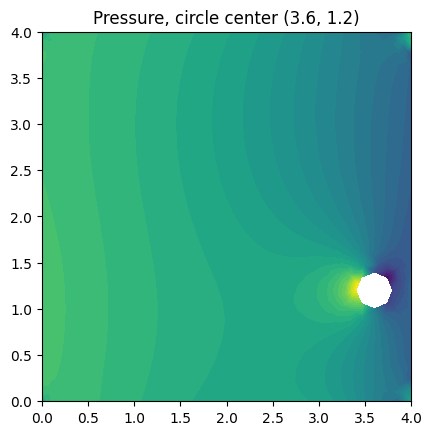

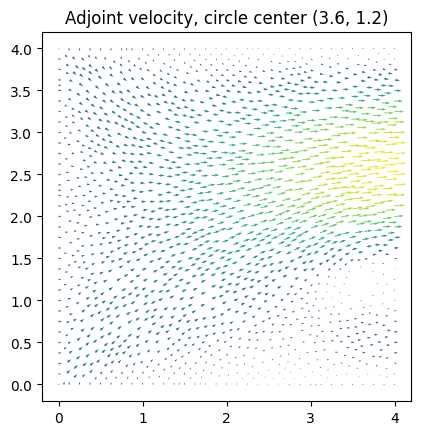

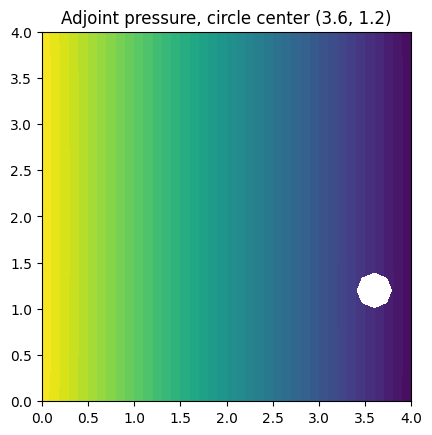

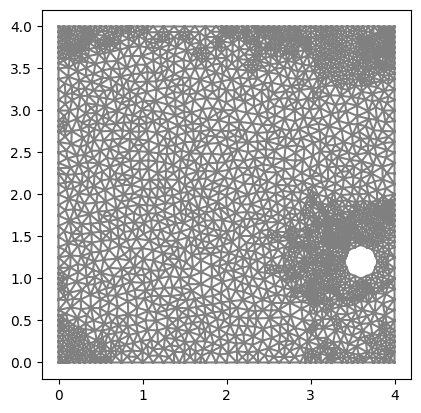

Total error = 0.00011653781147441601


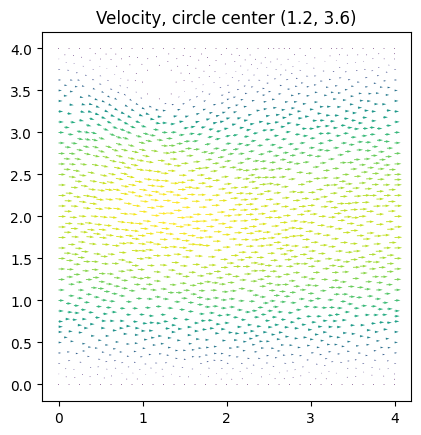

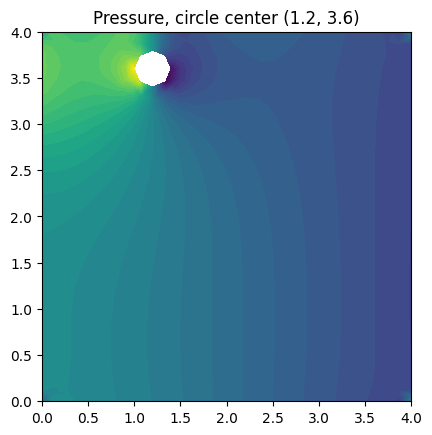

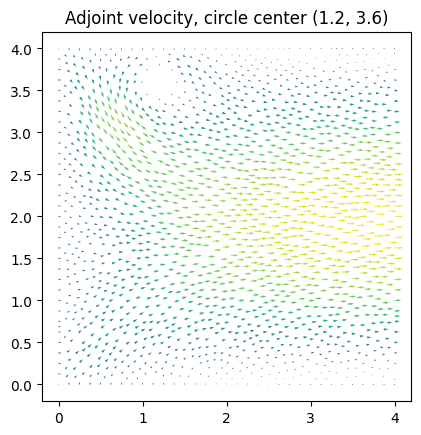

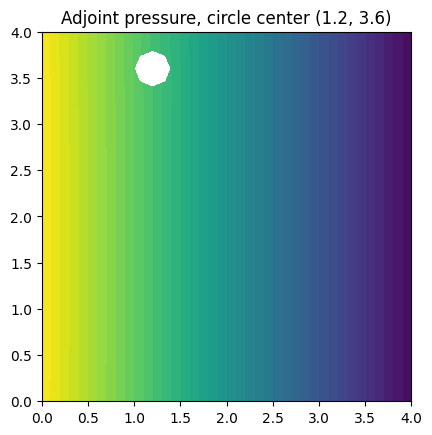

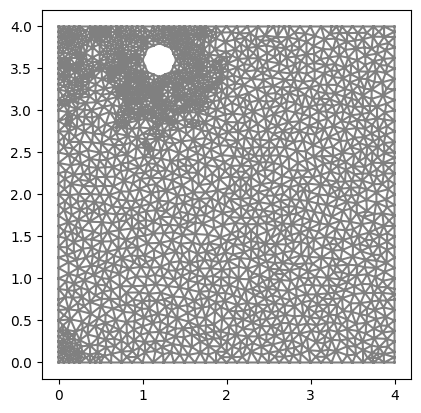

Total error = 0.00010873764575817465


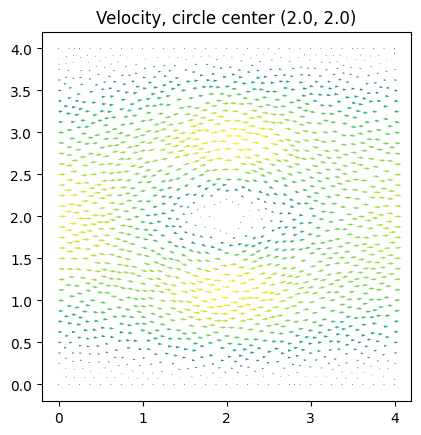

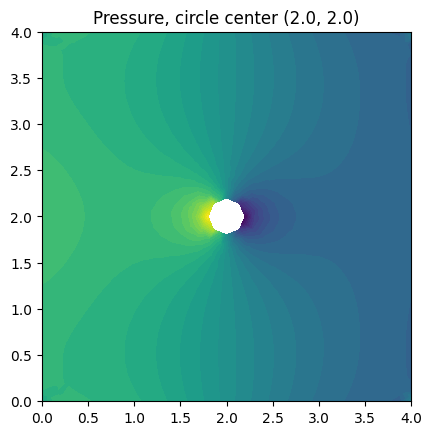

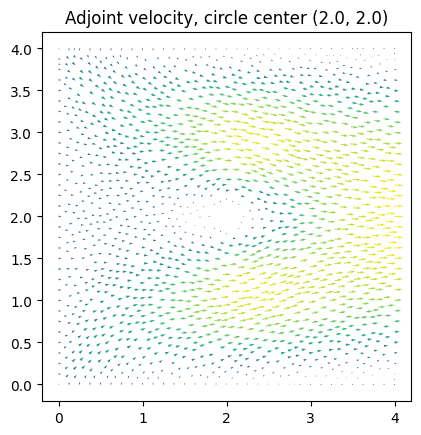

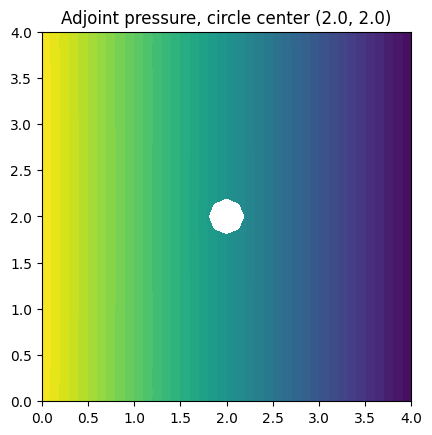

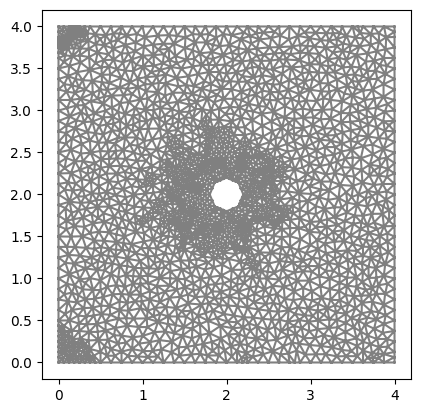

Total error = 8.116331113982016e-05


In [ ]:
!rm results-NS/*

nr = -1
for mesh in meshs:
  nr += 1
  # Define finite element approximation spaces
  
  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE
  
  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)
  
  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 
  
  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa
  
  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)
  
  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)
  
  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0
  
  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  
  
  # Results 
  
  
  
  # Define and solve variational problems
  
  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h
  
  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())
  
  # Set data that describe functional that defines the adjoint problem

  psi_1 = ("1.0","0.0")
  psi_2 = "0.0"
  psi_3drag = ("1.0","0.0")
  psi_3lift = ("0.0","1.0")
  psi_3both = ("1.0","1.0")

  psi_3 = ("0.0","0.0")
  #psi_3 = psi_3lift
  #psi_3 = psi_3drag

  psi1 = Expression(psi_1, element = V.ufl_element())
  psi2 = Expression(psi_2, element = Q.ufl_element())
  psi3 = Expression(psi_3, element = V.ufl_element())
  
  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )
  
  # Solve primal algebraic system 
  solve(res == 0, w) 
  
  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )
  
  # Solve adjoint algebraic system 
  solve(res_a == 0, wa)
  
  # Visualize solution and export files
  
  # Open files to export solution to Paraview
  file_u = File(f"results-Stokes/u_circ{circles[nr]}.pvd")
  file_p = File(f"results-Etokes/p_circ{circles[nr]}.pvd")
  file_phi = File(f"results-Stokes/phi_circ{circles[nr]}.pvd")
  file_theta = File(f"results-Etokes/theta_circ{circles[nr]}.pvd")
  
  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)
  
  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn
  
  # Plot solution
  plt.figure()
  plot(u_fcn, title=f"Velocity, circle center {circles[nr]}")
  
  plt.figure()
  plot(p_fcn, title=f"Pressure, circle center {circles[nr]}")
  
  plt.figure()
  plot(phi_fcn, title=f"Adjoint velocity, circle center {circles[nr]}")
  
  plt.figure()
  plot(theta_fcn, title=f"Adjoint pressure, circle center {circles[nr]}")
          
  plt.show()
  
  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')
  
  
  
  # Compute error indicators
  
  
  tot_err = float('inf')
  max_tot_err = 0.005
  
  # This is an adaptive algorithm that iterates until it has total error less than max_tot_err
  # max_tot_err = 1000 is used to make it only iterate ones
  
  while max_tot_err < tot_err:
    # Define function space over the elements of the mesh
  
    WDG = FunctionSpace(W.mesh(), "DG", 0)
    elm = TestFunction(WDG)
    err_ind = Function(WDG)
    
    # Compute local error indicators over the cells of the mesh 
    local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
    err_ind.vector()[:] = assemble(local_error)
    err_ind_abs = np.abs(err_ind.vector())
    err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()
    
    # Local mesh refinement (specified by a cell marker)
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)
    
    plt.figure()
    plot(mesh)
    plt.show()
    
    err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                  gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )
    
    tot_err = assemble(err_ind_sum)
    s = 'Total error = ' + repr(tot_err) 
    print(s)

    if tot_err < max_tot_err:
      break
    
    # Update trial and test functions
    
    W = FunctionSpace(mesh, WE)
    V = FunctionSpace(mesh, VE)
    Q = FunctionSpace(mesh, QE)
    
    w = Function(W)
    (u, p) = (as_vector((w[0],w[1])), w[2])
    (v, q) = TestFunctions(W) 

    # Update adjoint trial and test functions
    
    Wa = FunctionSpace(mesh, WEa)
    Va = FunctionSpace(mesh, VEa)
    Qa = FunctionSpace(mesh, QEa)
    
    wa = Function(Wa)
    (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
    (va, qa) = TestFunctions(Wa)
  
    h = CellDiameter(mesh)
    C = 1.0e3
    gamma = C/h
    
    f = Expression(("0.0","0.0"), element = V.ufl_element())
    
    psi1 = Expression(psi_1, element = V.ufl_element())
    psi2 = Expression(psi_2, element = Q.ufl_element())
    psi3 = Expression(psi_3, element = V.ufl_element())  

    # Define primal variational problem on residual form: r(u,p;v,q) = 0
    res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )
    
    # Solve primal algebraic system 
    solve(res == 0, w) 
    
    # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
    res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
              gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds 
            - inner(va, psi1)*dx - qa*psi2*dx )
    
    # Solve adjoint algebraic system 
    solve(res_a == 0, wa)
  

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.


1. The domain

For the functional corresponding to the drag force, $\psi_1 = (0,0), \psi_2 = 0, \psi_3 = (1, 0)$ we compute the velocity and pressure solution of the Stokes Equation, and their adjoint counterparts. We do that for four different circles. 

We see that the adjoint velocity has a vortex above and below the circle, for those circles that it can, that is sometimes there is a vortex only above/below. Meanwhile the adjoint pressure resembles the pressure solution. That is there is a spike in pressure to the left of the circle and decrease to the right of it. This is due to the fact that the adjoint velocity is going from the left to the right where the circle is.

The mesh refinement is most close to the circle but also near the edges above and below the circle.

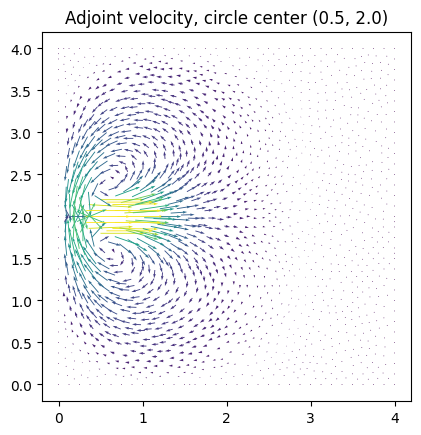
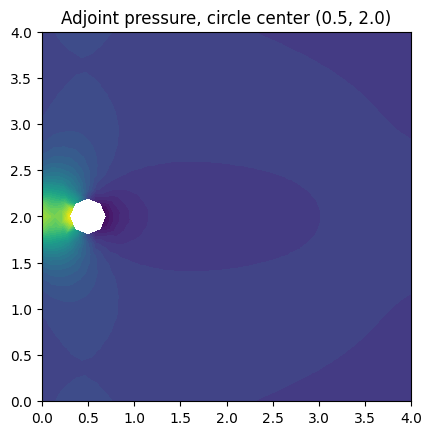
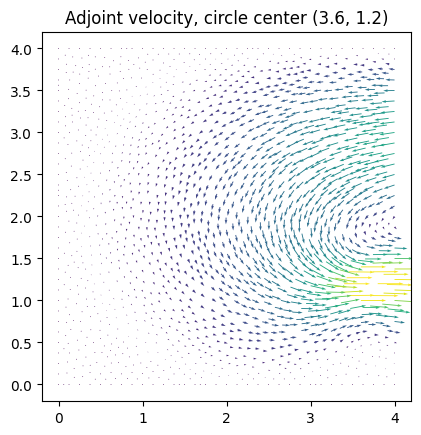
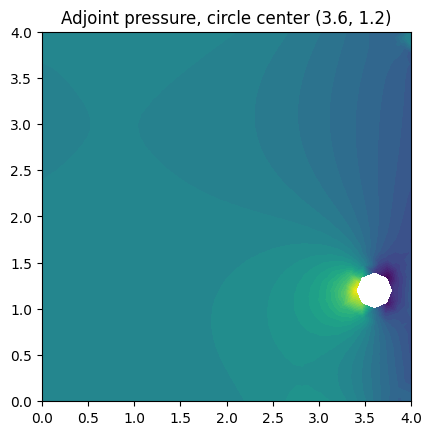

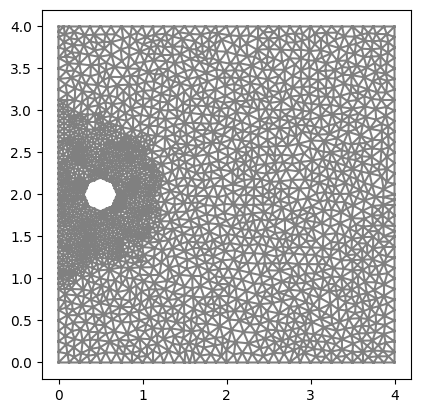
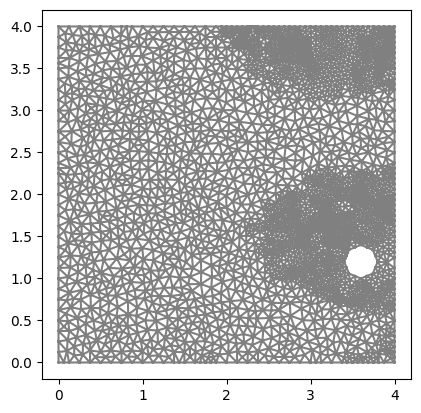

2. The functional

For the functional corresponding to the lift force, $\psi_1 = (0,0), \psi_2 = 0, \psi_3 = (0, 1)$. The adjoint solutions closely resemble that of the functional corresponding to the drag force. But the vortices are to the left and right for the adjoint velocity field. And the spike in pressure of the adjoint pressure is below the circle but not to the left of it. Which is, like we talked about in (1.), because the adjoint velocity flow from down to up at the circle location.


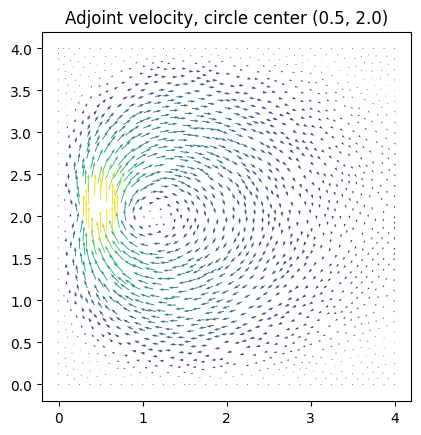
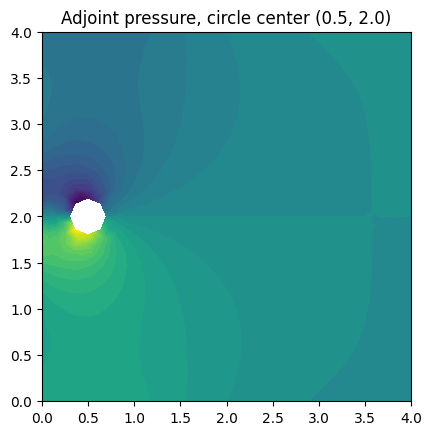
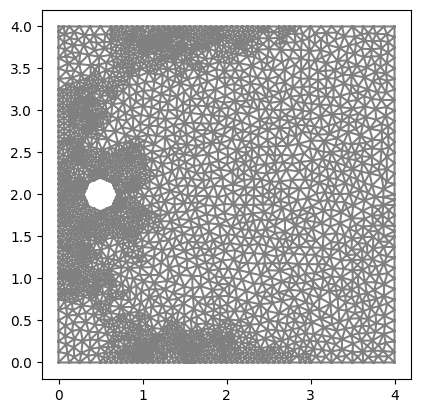

To get a feel of how the adjoint solution behaves for different $\psi$ we only change one $\psi_i$ at a time and have the others 0.

We see that if $\psi_1$ is changed while the other are kept 0. The adjoint pressure is almost linear in the direction of $\psi_1$ but has a spike near the edge of the outflow and dips at the other edge. (in the same direction as the $y$ component of $\psi_3$) It also deforms a little around the circle. Here $\psi_1 = (1,-1)$.

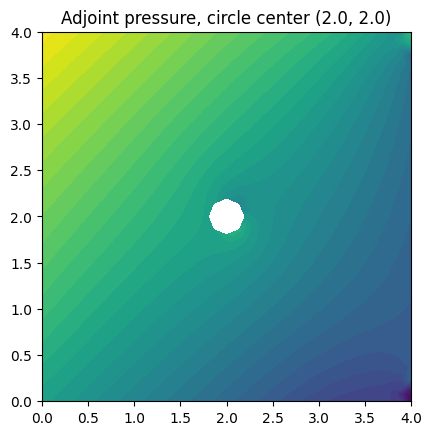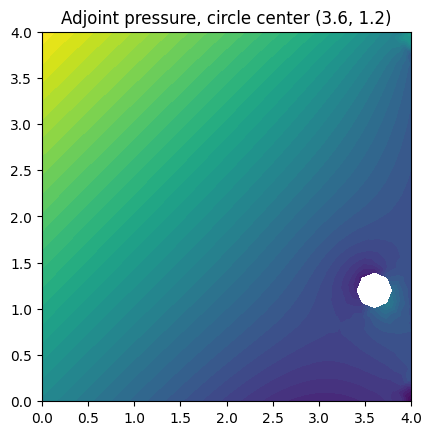

If the $y$ component of $\psi_1$ is non-negative we get a vortex around the center of the outflow in the adjoint velocity from high pressure to low. If the $y$ component is 0 the adjoint velocity is similar ot the velocity solution except that the highest velocity is close to the outflow and not the around the circle.

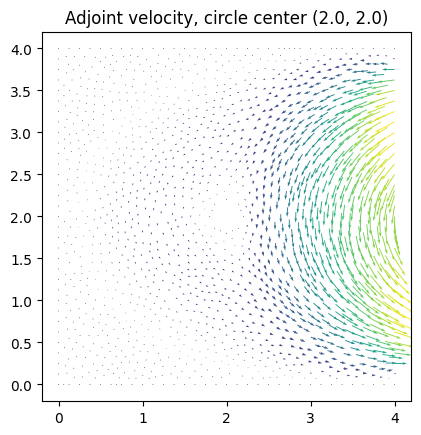

And the mesh changes most around the circle, around the vortex if it exists and a little bit around the edges of the inflow.

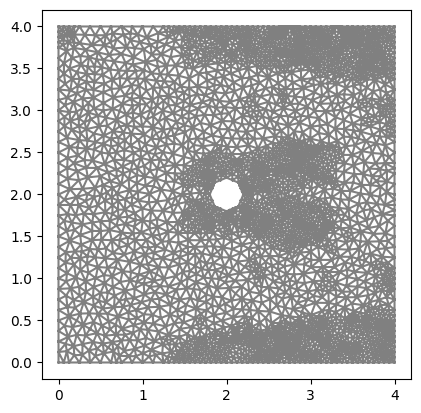

Now we look at $\psi_2 = 1$. Then the adjoint velocity goes in the opposite directtion of the velocity and is greatest near the center of the outflow boundary. While the adjoint pressure resembles the pressure solution. 

And the mesh is most refined near the circle and where the velocity is low.

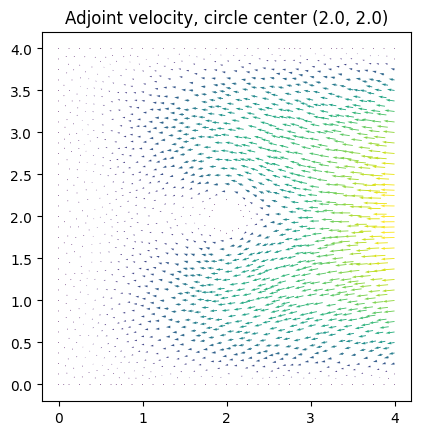
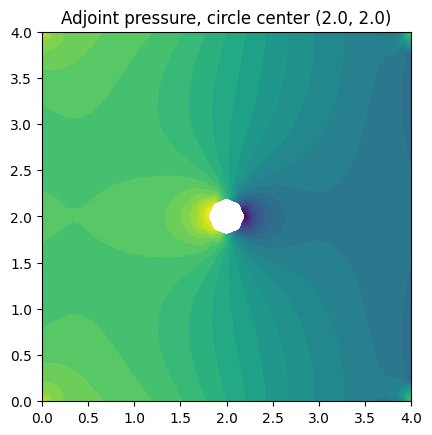
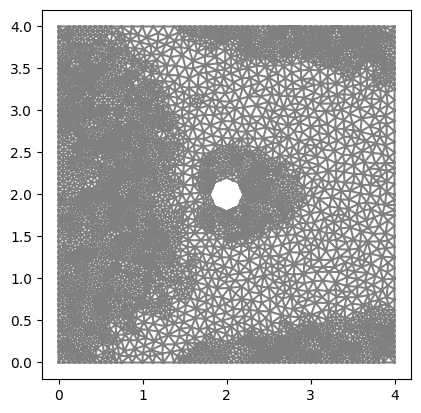

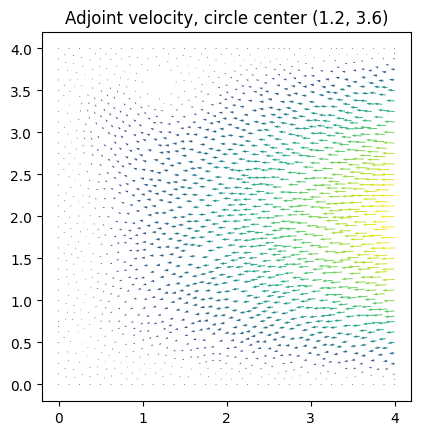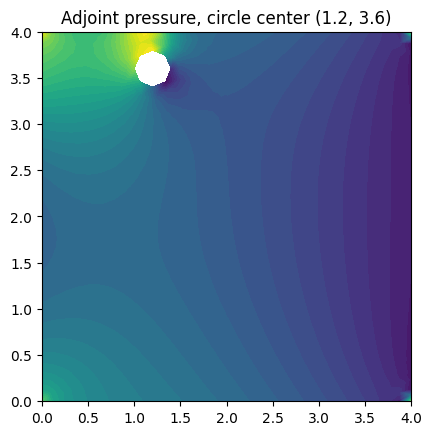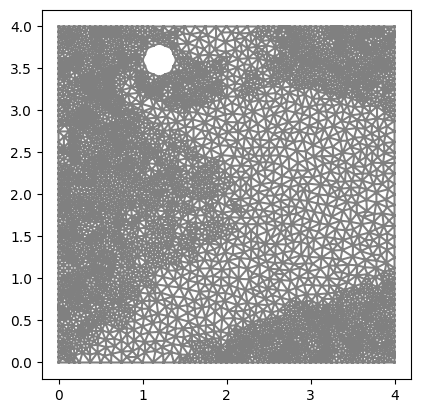

2. (Extra) Adaptive algorithm

For the adaptive algorithm we compute the local error and in every iteration we update those that have a higher local error than the average local error. And we iterate until the total error is less than a specified tolerance (max_total_error). For each iteration we solve both problems, adjoint problem and the Stokes equation in order to compute the a posteriori error estimation of the solution for the new mesh.

We also noted that if the primal and adjoint problems are approximated in the same space then they give us a total error that is close to zero, and thus we can get convergence of the total error when the mesh is refined. (1. (Extra) The total error)